In [1]:
import matplotlib.pyplot as plt
from math import log,exp
from matplotlib import style
style.use('fivethirtyeight')
from sklearn.datasets.samples_generator import make_blobs
import numpy as np
from scipy.stats import multivariate_normal
from math import pi
import pickle

def prob(mu,cov,x):
    reg_cov = 1e-9*np.ones([len(cov)])
    cov = np.add(cov, reg_cov)
    diff = np.subtract(x,mu)
    inside = 0.0
    pro = 1
    for i in range(len(cov)):
        inside += pow(diff[i],2)/cov[i]
        pro *= cov[i]
    inside *= -0.5
    new = pow(2*pi,len(cov))*pro
    new = pow(new,0.5)
    return (np.exp(inside)/(new*1.0))

X = np.loadtxt("NLS_Group05/Class1.txt")    
newX = np.loadtxt("NLS_Group05/Class2.txt")

In [2]:
class K_Means:
    def __init__(self, k=4, tol=0.001, max_iter=30):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter

    def fit(self,data):
        print "Starting K-means....with",self.k,"clusters...",self.max_iter,"iterations"

        self.centroids = {}

        for i in range(self.k):
            self.centroids[i] = data[i]

        for ii in range(self.max_iter):
            
            print ii,
            self.classifications = {}

            for i in range(self.k):
                self.classifications[i] = []

            for featureset in data:
                distances = [np.linalg.norm(featureset-self.centroids[centroid]) for centroid in self.centroids]
                classification = distances.index(min(distances))
                self.classifications[classification].append(featureset)

            prev_centroids = dict(self.centroids)
            chom = []
            for classification in self.classifications:
                chom.append(len(self.classifications[classification]))
                self.centroids[classification] = np.average(self.classifications[classification],axis=0)
#                 print len(self.classifications[classification])
            
#             print chom
            total_error = 0.0
#             print len(self.classifications)
            for c in self.centroids:
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                for jj in self.classifications[c]:
                    val1 = np.linalg.norm(jj-original_centroid)
                    val2 = np.linalg.norm(jj-current_centroid)
                    total_error += abs(val1-val2)
#                     print val1,val2,total_error
            
#             print total_error
            if (total_error<self.tol):
                print "K-means converged"
                break
#             print self.cen/troids

    def predict(self,data):
        distances = [np.linalg.norm(data-self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification

class GMM:
    def __init__(self,X,number_of_sources,iterations,tolerence):
        self.iterations = iterations
        self.number_of_sources = number_of_sources
        self.X = X
        self.mu = None
        self.pi = None
        self.cov = None
        self.XY = None
        self.tolerence = tolerence
        self.N = len(self.X)
        self.D = len(self.X[0])
        self.log_likelihoods = [] 
    
    """Define a function which runs for iterations, iterations"""
    def run(self):
        """ 1. Set the initial mu, covariance and pi values"""
        clf = K_Means(self.number_of_sources)
        clf.fit(self.X)
        self.mu = np.array(clf.centroids.values())
        print "K-means Complete...."
        
        self.data_clusters = np.array(clf.classifications.values())
        
        self.cov = np.ones([self.number_of_sources,self.D])
        
        for cn in range(self.number_of_sources):    
            covar=np.var(self.data_clusters[cn], axis=0)
            for k in range(self.D):
                self.cov[cn][k]=1.0*covar[k] 
                
        self.pi = np.ones(self.number_of_sources)/self.number_of_sources # Are "Fractions"
        for cn in range(self.number_of_sources):
            self.pi[cn] = len(self.data_clusters[cn])/(self.N*1.0)
            
        self.gamma = np.zeros((len(self.X),self.number_of_sources))
        
        
        """Plot the initial state"""            
        for ii in range(self.iterations): 
            print ii,
            sum_denom = []
#             print "a",
            for i in range(self.N):
                temp = 0.0
                for j in range(self.number_of_sources):
                    temp += self.pi[j]*prob(self.mu[j],self.cov[j],self.X[i])
                sum_denom.append(temp)
#             print "b",
            for i in range(self.N):
                for j in range(self.number_of_sources):
                    self.gamma[i][j] = self.pi[j]*prob(self.mu[j],self.cov[j],self.X[i])
                    if(sum_denom[i]>0):
                        self.gamma[i][j] /= sum_denom[i] 
            
#             print "c",
            sum2 = []
            for i in range(self.number_of_sources):
                temp = 0.0
                for j in range(self.N):
                    temp += self.gamma[j][i]
                sum2.append(temp)
#             print "d",              
            for i in range(self.number_of_sources):
                self.pi[i] = sum2[i]/len(self.X)
            
#             print "e",
            for i in range(self.number_of_sources):
                tot = np.zeros([self.D])
                for j in range(self.N):
                    a = np.array([self.X[j] - self.mu[i]])
                    tot = np.add(tot,self.gamma[j][i] * np.square(a))
                self.cov[i] = tot/(sum2[i]*1.0)
            
#             print "f",
            for i in range(self.number_of_sources):
                tot = np.zeros([self.D])
                for j in range(self.N):
                    tot += self.gamma[j][i] * self.X[j]
                self.mu[i] = tot/sum2[i]
                                
#             print "g",
#             print self.cov
            
            
            hig=0.0
            for i in range(len(self.X)):
                chigg = 0.0
                for j in range(self.number_of_sources):
#                     print i,j,self.pi[j],len(self.mu[j]),len(self.cov[j]),len(self.X[i])
                    chigg += self.pi[j] * prob(self.mu[j],self.cov[j],self.X[i])
                hig += np.log(chigg)
            self.log_likelihoods.append(hig)
            
#             print hig,
            
            try:
                if(abs(self.log_likelihoods[-1]-self.log_likelihoods[-2])<self.tolerence):
                    "TOLERANCE REACHED........"
                    break
            except:
                pass
            """
            This process of E step followed by a M step is now iterated a number of n times. In the second step for instance,
            we use the calculated pi_new, mu_new and cov_new to calculate the new r_ic which are then used in the second M step
            to calculat the mu_new2 and cov_new2 and so on....
            """
    
    def predict2(self,Y):
        result = []
        count = 0
        for k in Y:
            tot = 0.0
            for i in range(self.number_of_sources):
                m = self.mu[i]
                c = self.cov[i]
                tot += self.pi[i]*prob(m,c,k)
            
            result.append(np.log(tot))
            count+=1
        return np.array(result)

In [3]:
import numpy as np
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.mlab as mlab
import pickle

legend_facecolor='#f6ffc6'
legend_edgecolor='#ff07ff'
legend_linewidth=2
legend_loc='upper right'

c={}
c[1]='#54bdff' # blue Class Color
c[2]='#9ef442' # green
c[3]='#FFB74D' # red

c2={}
c2[1]='#2205c4' # Training Points Color
c2[2]='#388E3C'
c2[3]='#ad061f'

# GMM on BoVW

In [9]:
train_data1 = np.loadtxt('BovW/10/training_2b_c1_32')
train_data2 = np.loadtxt('BovW/10/training_2b_c2_32')
train_data3 = np.loadtxt('BovW/10/training_2b_c3_32')
total_train_data = np.loadtxt('BovW/10/training_2b_32')
# g3=GMM(X3,4,20,0.001)
# g3.run()

nc=4
ni=100
to=0.00001
acc=[]
for w in range(4):
    nc = pow(2,w)
    print "\n" + str(nc) + "\n"
    print "Gmm started....",
    g1=GMM(np.array(train_data1), nc,ni,to)
    g1.run()
    print "Gmm 1 done....",
    g2=GMM(np.array(train_data2), nc,ni,to)
    g2.run()
    print "Gmm 2 done....",
    g3=GMM(np.array(train_data3), nc,ni,to)
    g3.run()
    print "Gmm 3 done....",
    
    with open('BovW/10/2b_32_g1_'+str(nc),'wb') as handle:
        pickle.dump(g1, handle)
    with open('BovW/10/2b_32_g2_'+str(nc),'wb') as handle:
        pickle.dump(g2, handle)
    with open('BovW/10/2b_32_g3_'+str(nc),'wb') as handle:
        pickle.dump(g3, handle)
        
    test_data1 = np.loadtxt('BovW/10/test_2b_32_c1')
    test_data2 = np.loadtxt('BovW/10/test_2b_32_c2')
    test_data3 = np.loadtxt('BovW/10/test_2b_32_c3')
    total_test_data = np.loadtxt('BovW/10/test_2b_32')
    def stat():
        test_data_name = total_test_data
        res1=g1.predict2(np.array(test_data_name))
        res2=g2.predict2(np.array(test_data_name))
        res3=g3.predict2(np.array(test_data_name))
        def dbb():
            ans=[]
            for i in range(0,len(res1)):
                val=1
                temp=res1[i]
                if(res2[i]>temp):
                    val=2
                    temp=res2[i]
                if(res3[i]>temp):
                    val=3
                ans.append(val)
            return ans
        ans= dbb()
        def conf_mat():
            m=[]
            count1=0
            count12=0
            count2=0
            count21=0
            count3=0
            count31=0
            for i in range(0, len(test_data1)):
                if(ans[i]==1):
                    count1 = count1+1;
                if(ans[i]==2):
                    count12 = count12+1;
            for i in range(len(test_data1), len(test_data1)+len(test_data2)):
                if(ans[i]==2):
                    count2 = count2+1;
                if(ans[i]==1):
                    count21 = count21+1;
            for i in range(len(test_data1)+len(test_data2), len(total_test_data)):
                if(ans[i]==3):
                    count3 = count3+1;
                if(ans[i]==1):
                    count31 = count31+1;
           #    print len(test_data1), count1
           #    print len(test_data2), count2
            mm=[count1,count12,len(test_data1)-count1-count12]
            m.append(mm)
            mm=[count21, count2, len(test_data2)-count21-count2]
            m.append(mm)
            mm=[count31, len(test_data3)-count31-count3, count3]
            m.append(mm)
            return m
        m=conf_mat()
        print m
        accuracy=(sum([m[i][i] for i in range(0,3)]))/(float)(sum([sum(m[i]) for i in range(0,3)]))
        precision=[m[i][i]/(float)(m[0][i]+m[1][i]+m[2][i]) for i in range(0,3)]
        recall=[m[i][i]/(float)(m[i][0]+m[i][1]+m[i][2]) for i in range(0,3)]
        f_measure=[(2*precision[i]*recall[i])/(precision[i]+recall[i]) for i in range(0,3)]
        mean_precision=sum([precision[i] for i in range(0,3)])/3.0
        mean_recall=sum([recall[i] for i in range(0,3)])/3.0
        mean_f_measure=sum([f_measure[i] for i in range(0,3)])/3.0
        prior=[len(train_data1)/(float)(len(total_train_data)),len(train_data2)/(float)(len(total_train_data)),
              len(train_data3)/(float)(len(total_train_data))]
                       
        print "Prior : {0}".format(prior)
        print "Confusion Matrix : {0}".format(m)
        print "Accuracy :",accuracy
        print "Precision :{0}".format(precision),"Mean Precision :",mean_precision
        print "Recall :{0}".format(recall),"Mean Recall :",mean_recall
        print "F-measure :{0}".format(f_measure),"Mean F-measure :",mean_f_measure
        acc.append([nc,accuracy]) 
        with open('2b_32_stats_'+str(nc),'wb') as handle:
            handle.write("Prior : {0}\n".format(prior))
            handle.write("Confusion Matrix : {0}\n".format(m))
            handle.write("Accuracy : "+str(accuracy)+"\n")
            handle.write("Precision :{0}".format(precision)+"\nMean Precision : "+str(mean_precision)+"\n")
            handle.write("Recall :{0}".format(recall)+"\nMean Recall : "+str(mean_recall)+"\n")
            handle.write("F-measure :{0}".format(f_measure)+"\nMean F-measure : "+str(mean_f_measure)+"\n")
    stat()
with open('BovW/10/2b_acc','wb') as handle:
    pickle.dump(acc, handle)
print "\n\n";


1

Gmm started.... Starting K-means....with 1 clusters... 30 iterations
0 1 K-means converged
K-means Complete....
0 1 Gmm 1 done.... Starting K-means....with 1 clusters... 30 iterations
0 1 K-means converged
K-means Complete....
0 1 Gmm 2 done.... Starting K-means....with 1 clusters... 30 iterations
0 1 K-means converged
K-means Complete....
0 1 Gmm 3 done.... [[26, 24, 0], [2, 41, 7], [4, 37, 9]]
Prior : [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
Confusion Matrix : [[26, 24, 0], [2, 41, 7], [4, 37, 9]]
Accuracy : 0.506666666667
Precision :[0.8125, 0.4019607843137255, 0.5625] Mean Precision : 0.592320261438
Recall :[0.52, 0.82, 0.18] Mean Recall : 0.506666666667
F-measure :[0.6341463414634146, 0.5394736842105263, 0.2727272727272727] Mean F-measure : 0.482115766134

2

Gmm started.... Starting K-means....with 2 clusters... 30 iterations
0 1 2 3 4 5 K-means converged
K-means Complete....
0 1 2 3 Gmm 1 done.... Starting K-means....with 2 clusters... 30 iterations
0 1 2

/home/serchirag/.local/lib/python2.7/site-packages/ipykernel_launcher.py:176: RuntimeWarning: divide by zero encountered in log


 2 3 Gmm 1 done.... Starting K-means....with 4 clusters... 30 iterations
0 1 2 3 4 5 6 7 K-means converged
K-means Complete....
0 1 2 3 4 Gmm 2 done.... Starting K-means....with 4 clusters... 30 iterations
0 1 2 K-means converged
K-means Complete....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 Gmm 3 done.... [[29, 5, 16], [1, 27, 22], [3, 8, 39]]
Prior : [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
Confusion Matrix : [[29, 5, 16], [1, 27, 22], [3, 8, 39]]
Accuracy : 0.633333333333
Precision :[0.8787878787878788, 0.675, 0.5064935064935064] Mean Precision : 0.68676046176
Recall :[0.58, 0.54, 0.78] Mean Recall : 0.633333333333
F-measure :[0.6987951807228915, 0.6000000000000001, 0.6141732283464567] Mean F-measure : 0.637656136356

8

Gmm started.... Starting K-means....with 8 clusters... 30 iterations
0 1 2 3 4 5 6 7 8 9 K-means converged
K-means Complete....
0 1 2 3 4 Gmm 1 done.... Starting K-means...

IOError: [Errno 2] No such file or directory: 'BovW/10/2b_32_g1_16'

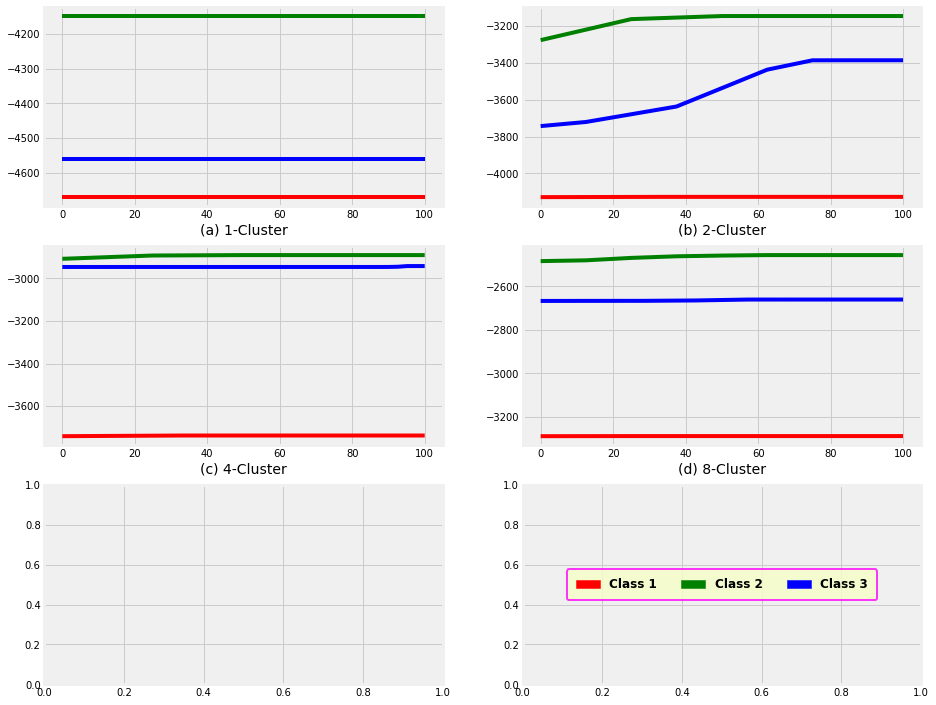

In [11]:
import numpy as np
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.mlab as mlab
import pickle

legend_facecolor='#f6ffc6'
legend_edgecolor='#ff07ff'
legend_linewidth=2
legend_loc='upper right'

c={}
c[1]='#54bdff' # blue Class Color
c[2]='#9ef442' # green
c[3]='#FFB74D' # red

c2={}
c2[1]='#2205c4' # Training Points Color
c2[2]='#388E3C'
c2[3]='#ad061f'

# matplotlib.style.use('seaborn')
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(14,14*0.89))
for w in range(5):
    nc = pow(2,w)
    plt.subplot(321+w)
    ax1.set_title(str(nc)+'-Cluster')
    
    with open('BovW/10/2b_32_g1_'+str(nc),'rb') as handle:
        g1=pickle.loads(handle.read())
        xx=np.linspace(0,100,len(g1.log_likelihoods))
        plt.plot(xx,g1.log_likelihoods,c='r')
    
    with open('BovW/10/2b_32_g2_'+str(nc),'rb') as handle: 
        g2=pickle.loads(handle.read())
        xx=np.linspace(0,100,len(g2.log_likelihoods))
        plt.plot(xx,g2.log_likelihoods,c='g')
        
    with open('BovW/10/2b_32_g3_'+str(nc),'rb') as handle: 
        g3=pickle.loads(handle.read())
        xx=np.linspace(0,100,len(g3.log_likelihoods))
        plt.plot(xx,g3.log_likelihoods,c='b') 

    colors = ['r','g','b']
    texts = ["Class 1", "Class 2", "Class 3"]
    handles = [plt.Rectangle((0,0),1,1,color=colors[i]) for i  in range(len(texts))]
    legend=ax6.legend(handles=handles, labels=texts,loc='center', ncol=3,frameon=1, 
                      labelspacing=1.5, borderpad=0.75, prop=dict(weight='black',size='large'))
    frame = legend.get_frame()
    frame.set_facecolor(legend_facecolor)
    frame.set_edgecolor(legend_edgecolor)
    frame.set_linewidth(legend_linewidth)
        #     plt.show()
    
    ad=ord('a')+w
    plt.xlabel('('+chr(ad)+') '+str(nc)+'-Cluster',fontsize=14)
plt.show()

[[1, 0.5066666666666667], [2, 0.5333333333333333], [4, 0.6333333333333333], [8, 0.68]]


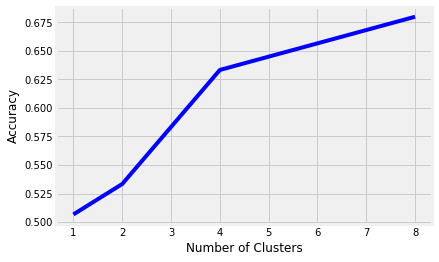

In [12]:
print acc
X=[acc[i][0] for i in range(0,len(acc)) ]
Y=[acc[i][1] for i in range(0,len(acc)) ]
plt.plot(X,Y,c='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Accuracy')
# plt.plot(acc)